In [1]:
from dotenv import load_dotenv
import os

import sqlite3
import asyncio
import aiosqlite

from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langchain_core.tools import tool
from langgraph.graph import START, StateGraph, END
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display
from langgraph.graph import MessagesState
from langchain_core.messages import HumanMessage, SystemMessage

from langchain_ollama import ChatOllama

In [2]:
load_dotenv("../chatbot/.env")

True

In [3]:
os.environ["LANGCHAIN_PROJECT"] = "llama3.2-calculator"

## Create tools

In [4]:
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: first int
        b: second int
    """
    return a + b

@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: first int
        b: second int
    """
    return a / b

@tool
def subtract(a:int, b:int) -> float:
    """subtract a and b.

    Args:
        a: first int
        b: second int
    """
    return a-b

In [5]:
tools = [add, multiply, divide, subtract]

In [6]:
model = ChatOllama(model="llama3.2", temperature=0)
model_with_tools = model.bind_tools(tools)

## streaming token works well if no tool binding

In [7]:
# Graph
builder = StateGraph(MessagesState)
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")
def assistant(state: MessagesState, config):
   message = [sys_msg] + state["messages"]
   model_response = model.invoke(
       message,
        config )
   return {"messages": model_response}


builder.add_node("assistant", assistant)
builder.add_edge("assistant", END)

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")

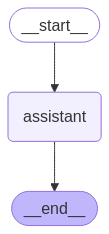

Here|'s| a| short| poem| I| came| up| with|:

Numbers| dance| in| my| mind|,
 of| digits| aligned|.
 too|,and| subtract|,| multiply|
|The| rhythm| of| math|,| forever| true|.

In| the| realm| of| numbers|,| I| roam| free|,
Where| |2| +| |2| equals| harmony|.
 beauty| of| math|,| it| never| fades|,
 that|'s| universal|,| in| every| shade|.

 to| decimals|,| I| explore|,
,| and| all| its| score|.
 reason|,| I| play|,
,| every| single| day|.||

In [8]:
config = {"configurable": {"thread_id": "no-tool"}}
async with AsyncSqliteSaver.from_conn_string("checkpoints.db") as memory:
    react_graph = builder.compile(checkpointer=memory)
    display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))
    async for event in react_graph.astream_events({"messages": [HumanMessage(content="write me a poem?")]}, 
                                                   config, version="v2", stream_mode="messages"):
  
        if event["metadata"].get("langgraph_node", "") == "assistant":
            if event["event"] == "on_chat_model_stream":
                data = event["data"]
                print(data["chunk"].content, end="|")

## streaming token doesn't work with tool binding 

In [9]:
# Graph
config = {"configurable": {"thread_id": "with-tool"}}
builder = StateGraph(MessagesState)
sys_msg = SystemMessage(content="You are a helpful assistant tasked with performing arithmetic on a set of inputs.")
def assistant(state: MessagesState, config):
   message = [sys_msg] + state["messages"]
   model_response = model_with_tools.invoke(
       message,
        config )
   return {"messages": model_response}

# Define nodes: these do the work
builder.add_node("assistant", assistant)
builder.add_node("tools", ToolNode(tools))

# Define edges: these determine how the control flow moves
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    tools_condition,
)
builder.add_edge("tools", "assistant")

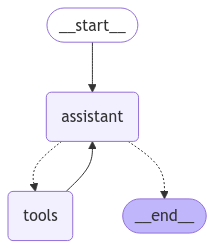

||The result of the expression 1 + 2 * 5 + 100 is 107.|

In [10]:
async with AsyncSqliteSaver.from_conn_string("checkpoints.db") as memory:
    react_graph = builder.compile(checkpointer=memory)
    display(Image(react_graph.get_graph(xray=True).draw_mermaid_png()))
    async for event in react_graph.astream_events({"messages": [HumanMessage(content="what is 1+2*5+100?")]}, 
                                                   config, version="v2", stream_mode="messages"):
  
        if event["metadata"].get("langgraph_node", "") == "assistant":
            if event["event"] == "on_chat_model_stream":
                data = event["data"]
                print(data["chunk"].content, end="|")
                print(data["ch

## Check history 

In [11]:
config = {"configurable": {"thread_id": "no-tool"}}
async with AsyncSqliteSaver.from_conn_string("checkpoints.db") as memory:
    result = await memory.aget_tuple(config)
    print(result)

CheckpointTuple(config={'configurable': {'thread_id': 'no-tool', 'checkpoint_ns': '', 'checkpoint_id': '1eff7b87-86a6-6836-8001-c8c0cfad1196'}}, checkpoint={'v': 1, 'ts': '2025-03-02T22:48:33.805681+00:00', 'id': '1eff7b87-86a6-6836-8001-c8c0cfad1196', 'channel_values': {'messages': [HumanMessage(content='write me a poem?', additional_kwargs={}, response_metadata={}, id='b2454975-899c-484e-b02f-235debfd2d3a'), AIMessage(content="Here's a short poem I came up with:\n\nNumbers dance in my mind,\nA symphony of digits aligned.\nAdd and subtract, multiply too,\nThe rhythm of math, forever true.\n\nIn the realm of numbers, I roam free,\nWhere 2 + 2 equals harmony.\nThe beauty of math, it never fades,\nA language that's universal, in every shade.\n\nFrom fractions to decimals, I explore,\nThe world of numbers, and all its score.\nI calculate, I reason, I play,\nIn the game of math, every single day.", additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-03-02T22:4

In [12]:
config = {"configurable": {"thread_id": "with-tool"}}
async with AsyncSqliteSaver.from_conn_string("checkpoints.db") as memory:
    result = await memory.aget_tuple(config)
    print(result)

CheckpointTuple(config={'configurable': {'thread_id': 'with-tool', 'checkpoint_ns': '', 'checkpoint_id': '1eff7b87-e4fb-695e-8003-e560c75c5cbf'}}, checkpoint={'v': 1, 'ts': '2025-03-02T22:48:43.697151+00:00', 'id': '1eff7b87-e4fb-695e-8003-e560c75c5cbf', 'channel_values': {'messages': [HumanMessage(content='what is 1+2*5+100?', additional_kwargs={}, response_metadata={}, id='00052d4b-116c-448e-af07-a2b728010fef'), AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.2', 'created_at': '2025-03-02T22:48:43.103775Z', 'done': True, 'done_reason': 'stop', 'total_duration': 1491490625, 'load_duration': 38013625, 'prompt_eval_count': 414, 'prompt_eval_duration': 1005000000, 'eval_count': 22, 'eval_duration': 446000000, 'message': {'role': 'assistant', 'content': '', 'images': None, 'tool_calls': None}}, id='run-5ea72cee-84de-4be8-9476-e4a935cae336', tool_calls=[{'name': 'add', 'args': {'a': 7, 'b': 100}, 'id': '8527c5a3-23e8-4bdc-bb1b-9e1f5395d5f8', 'type': 'tool_ca